# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 4

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [23]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [24]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.751
[2] loss: 0.911
[3] loss: 0.395
[4] loss: 0.243
[5] loss: 0.149
[6] loss: 0.063
[7] loss: 0.036
[8] loss: 0.024
[9] loss: 0.018
[10] loss: 0.016
[11] loss: 0.012
[12] loss: 0.009
[13] loss: 0.008
[14] loss: 0.009
[15] loss: 0.006
[16] loss: 0.006
[17] loss: 0.008
[18] loss: 0.006
[19] loss: 0.004
[20] loss: 0.003


In [25]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 4])

In [26]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

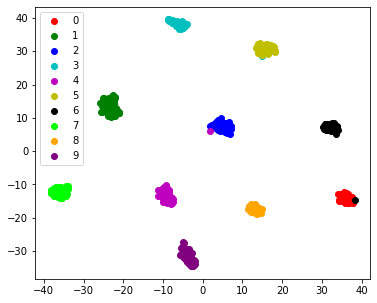

In [27]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

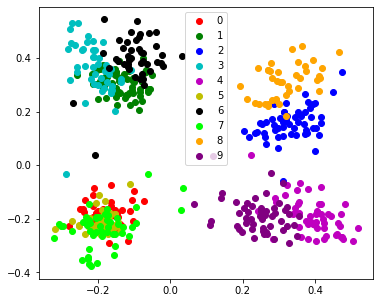

In [28]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [29]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [30]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [31]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.1712, -0.1225,  0.3385, -0.2133,  0.4019, -0.1858, -0.0899, -0.1789,
          0.3463,  0.2684],
        [ 0.3703,  0.4155,  0.4208, -0.2127, -0.1745, -0.2089,  0.0628,  0.5512,
         -0.1534,  0.2218],
        [-0.1786,  0.2908,  0.1560,  0.3565, -0.2117, -0.2177,  0.3843, -0.2305,
          0.3059, -0.1961],
        [ 0.5840, -0.2118,  0.3562, -0.2608,  0.2416,  0.1138,  0.4157, -0.0629,
         -0.1211, -0.2771]])

In [32]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/f1_{y_dim}.pt')

In [33]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [34]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [35]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,4,4)
torch.save(f2.state_dict(), f'./result/f2_{y_dim}.pt')

# Gauss Mixture

In [4]:
class prob_gauss_mix(nn.Module):
    def __init__(self, n, m):
        super(prob_gauss_mix, self).__init__()
        self.mu = nn.Linear(n, m, bias=False)
        self.cov = nn.ConvTranspose2d(n, 1, m, bias=False)
        self.n, self.m = n, m
    
    def forward(self, x):
        mu = self.mu(x)
        cov = self.cov(x.view(-1, self.n, 1, 1)).view(-1, self.m, self.m)
        return mu + torch.bmm(cov, torch.randn_like(mu.view(-1, self.m, 1))).view(-1, self.m)

In [37]:
gm = prob_gauss_mix(10, 4)
gm.mu.load_state_dict(torch.load('./result/f1_4.pt'))
gm.cov.load_state_dict(torch.load('./result/f2_4.pt'))

<All keys matched successfully>

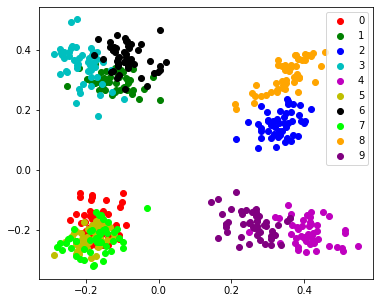

In [38]:
data = torch.eye(10).repeat(50,1)
lab = np.tile(range(10), 50)
f3 = gm(data).detach().numpy()

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f3[lab == i, 0], f3[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

# Train

In [3]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_1.cfg')

['./config/sswae_dev2_1_1.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 4
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.278407e-01  D: 6.935628e-01  D2: 2.143771e-02  D3: 2.176326e-03
test loss: 1.675589e-01  D: 7.016225e-01  D2: 1.871433e-03  D3: 9.751352e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.655839e-01  D: 6.955358e-01  D2: -3.177098e-03  D3: 7.242588e-03
test loss: 1.560704e-01  D: 7.273507e-01  D2: -3.781071e-03  D3: 8.608323e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.460965e-01  D: 6.982212e-01  D2: -4.345967e-03  D3: 1.105913e-02
test loss: 1.382481e-01  D: 6.889966e-01  D2: -5.333834e-03  D3: 1.143291e-02


[default |INFO|model.py:1280] [04/80]  loss: 1.300727e-01  D: 6.988887e-01  D2: -4.202932e-03  D3: 1.250446e-02
test loss: 1.394905e-01  D: 6.965199e-01  D2: -2.874508e-03  D3: 1.656490e-02


[default |INFO|model.py:1280] [05/80]  loss: 1.172132e-01  D: 6.941569e-01  D2: -4.258723e-03  D3: 1.519755e-02
test loss: 1.035405e-01  D: 6.983630e-01  D2: -4.422770e-03  D3: 1.654591e-02


[default |INFO|model.py:1280] [06/80]  loss: 9.876778e-02  D: 6.947382e-01  D2: -4.842048e-03  D3: 1.383853e-02
test loss: 9.374828e-02  D: 6.826982e-01  D2: -4.561405e-03  D3: 1.538357e-02


[default |INFO|model.py:1280] [07/80]  loss: 9.225380e-02  D: 6.947352e-01  D2: -4.915600e-03  D3: 1.440422e-02
test loss: 9.446781e-02  D: 6.953487e-01  D2: -5.617018e-03  D3: 1.542083e-02


[default |INFO|model.py:1280] [08/80]  loss: 9.131129e-02  D: 6.943811e-01  D2: -5.214677e-03  D3: 1.466092e-02
test loss: 8.195451e-02  D: 6.988112e-01  D2: -5.004816e-03  D3: 1.379299e-02


[default |INFO|model.py:1280] [09/80]  loss: 8.586396e-02  D: 6.945007e-01  D2: -5.179667e-03  D3: 1.344244e-02
test loss: 8.769573e-02  D: 6.835057e-01  D2: -5.834398e-03  D3: 1.440525e-02


[default |INFO|model.py:1280] [10/80]  loss: 8.395462e-02  D: 6.937131e-01  D2: -5.391301e-03  D3: 1.370154e-02
test loss: 8.461640e-02  D: 6.935644e-01  D2: -5.142269e-03  D3: 1.590403e-02


[default |INFO|model.py:1280] [11/80]  loss: 8.101493e-02  D: 6.946423e-01  D2: -5.462437e-03  D3: 1.346004e-02
test loss: 7.729491e-02  D: 6.978878e-01  D2: -5.462265e-03  D3: 1.233111e-02


[default |INFO|model.py:1280] [12/80]  loss: 7.868735e-02  D: 6.940474e-01  D2: -5.689168e-03  D3: 1.361083e-02
test loss: 7.656367e-02  D: 7.008896e-01  D2: -6.161547e-03  D3: 1.301502e-02


[default |INFO|model.py:1280] [13/80]  loss: 7.697156e-02  D: 6.941528e-01  D2: -5.980921e-03  D3: 1.355117e-02
test loss: 7.370889e-02  D: 6.883733e-01  D2: -6.536493e-03  D3: 1.366109e-02


[default |INFO|model.py:1280] [14/80]  loss: 7.387200e-02  D: 6.937075e-01  D2: -6.280665e-03  D3: 1.349509e-02
test loss: 7.178245e-02  D: 6.895364e-01  D2: -6.138477e-03  D3: 1.245304e-02


[default |INFO|model.py:1280] [15/80]  loss: 7.281810e-02  D: 6.938372e-01  D2: -6.227647e-03  D3: 1.362583e-02
test loss: 7.340135e-02  D: 6.843482e-01  D2: -6.316471e-03  D3: 1.360185e-02


[default |INFO|model.py:1280] [16/80]  loss: 7.144836e-02  D: 6.944459e-01  D2: -6.463583e-03  D3: 1.311925e-02
test loss: 7.195689e-02  D: 6.852754e-01  D2: -6.790562e-03  D3: 1.030394e-02


[default |INFO|model.py:1280] [17/80]  loss: 7.181034e-02  D: 6.928201e-01  D2: -6.448194e-03  D3: 1.345279e-02
test loss: 7.004399e-02  D: 6.933007e-01  D2: -6.378984e-03  D3: 1.456154e-02


[default |INFO|model.py:1280] [18/80]  loss: 6.908850e-02  D: 6.945388e-01  D2: -6.944785e-03  D3: 1.288071e-02
test loss: 6.690271e-02  D: 6.826503e-01  D2: -6.790304e-03  D3: 1.384663e-02


[default |INFO|model.py:1280] [19/80]  loss: 6.671514e-02  D: 6.931319e-01  D2: -6.746001e-03  D3: 1.324163e-02
test loss: 6.653425e-02  D: 6.756223e-01  D2: -7.305727e-03  D3: 1.280082e-02


[default |INFO|model.py:1280] [20/80]  loss: 6.750323e-02  D: 6.925626e-01  D2: -7.157979e-03  D3: 1.320198e-02
test loss: 6.819465e-02  D: 6.835941e-01  D2: -7.661142e-03  D3: 1.472653e-02


[default |INFO|model.py:1280] [21/80]  loss: 6.673995e-02  D: 6.946373e-01  D2: -7.127805e-03  D3: 1.299630e-02
test loss: 6.699816e-02  D: 6.965225e-01  D2: -7.367792e-03  D3: 1.398632e-02


[default |INFO|model.py:1280] [22/80]  loss: 6.631187e-02  D: 6.938773e-01  D2: -7.351325e-03  D3: 1.308036e-02
test loss: 6.611150e-02  D: 6.932131e-01  D2: -7.471857e-03  D3: 1.173325e-02


[default |INFO|model.py:1280] [23/80]  loss: 6.556340e-02  D: 6.936098e-01  D2: -7.354646e-03  D3: 1.275404e-02
test loss: 6.514575e-02  D: 6.991850e-01  D2: -7.714825e-03  D3: 1.094791e-02


[default |INFO|model.py:1280] [24/80]  loss: 6.632471e-02  D: 6.941656e-01  D2: -7.541108e-03  D3: 1.272746e-02
test loss: 6.903208e-02  D: 6.725807e-01  D2: -7.804308e-03  D3: 1.171402e-02


[default |INFO|model.py:1280] [25/80]  loss: 6.787619e-02  D: 6.936454e-01  D2: -7.527719e-03  D3: 1.217753e-02
test loss: 6.752837e-02  D: 6.887164e-01  D2: -7.647839e-03  D3: 1.235012e-02


[default |INFO|model.py:1280] [26/80]  loss: 6.525047e-02  D: 6.944442e-01  D2: -7.618035e-03  D3: 1.243244e-02
test loss: 6.597913e-02  D: 6.926811e-01  D2: -7.398024e-03  D3: 1.538914e-02


[default |INFO|model.py:1280] [27/80]  loss: 6.415045e-02  D: 6.926972e-01  D2: -7.807722e-03  D3: 1.205587e-02
test loss: 6.478022e-02  D: 6.904523e-01  D2: -7.750311e-03  D3: 1.168469e-02


[default |INFO|model.py:1280] [28/80]  loss: 6.332583e-02  D: 6.936936e-01  D2: -7.823580e-03  D3: 1.237997e-02
test loss: 6.486109e-02  D: 6.917892e-01  D2: -7.850246e-03  D3: 1.556425e-02


[default |INFO|model.py:1280] [29/80]  loss: 6.267830e-02  D: 6.935355e-01  D2: -7.954841e-03  D3: 1.272559e-02
test loss: 6.205921e-02  D: 6.924903e-01  D2: -8.429966e-03  D3: 1.060604e-02


[default |INFO|model.py:1280] [30/80]  loss: 6.245204e-02  D: 6.941899e-01  D2: -8.043847e-03  D3: 1.255692e-02
test loss: 6.205763e-02  D: 7.010760e-01  D2: -8.489170e-03  D3: 1.317057e-02


[default |INFO|model.py:1280] [31/80]  loss: 6.254496e-02  D: 6.934824e-01  D2: -8.022561e-03  D3: 1.250108e-02
test loss: 6.120504e-02  D: 6.918992e-01  D2: -8.596239e-03  D3: 1.108492e-02


[default |INFO|model.py:1280] [32/80]  loss: 6.123150e-02  D: 6.939779e-01  D2: -8.257558e-03  D3: 1.257267e-02
test loss: 6.094907e-02  D: 6.913361e-01  D2: -8.481779e-03  D3: 1.266550e-02


[default |INFO|model.py:1280] [33/80]  loss: 6.103285e-02  D: 6.939419e-01  D2: -8.326484e-03  D3: 1.234466e-02
test loss: 6.185256e-02  D: 6.899572e-01  D2: -8.784685e-03  D3: 1.146923e-02


[default |INFO|model.py:1280] [34/80]  loss: 5.978865e-02  D: 6.930086e-01  D2: -8.473037e-03  D3: 1.257760e-02
test loss: 6.030695e-02  D: 6.927496e-01  D2: -7.975521e-03  D3: 1.279893e-02


[default |INFO|model.py:1280] [35/80]  loss: 5.985496e-02  D: 6.940199e-01  D2: -8.500886e-03  D3: 1.263730e-02
test loss: 6.092752e-02  D: 6.928858e-01  D2: -8.646574e-03  D3: 1.382392e-02


[default |INFO|model.py:1280] [36/80]  loss: 6.093091e-02  D: 6.935001e-01  D2: -8.460617e-03  D3: 1.224716e-02
test loss: 6.149113e-02  D: 6.920912e-01  D2: -8.633842e-03  D3: 1.027947e-02


[default |INFO|model.py:1280] [37/80]  loss: 5.941104e-02  D: 6.937800e-01  D2: -8.693380e-03  D3: 1.252216e-02
test loss: 6.100284e-02  D: 7.039497e-01  D2: -8.154345e-03  D3: 1.041278e-02


[default |INFO|model.py:1280] [38/80]  loss: 5.948216e-02  D: 6.932588e-01  D2: -8.628748e-03  D3: 1.221397e-02
test loss: 6.270349e-02  D: 6.983673e-01  D2: -8.654814e-03  D3: 1.110037e-02


[default |INFO|model.py:1280] [39/80]  loss: 6.014005e-02  D: 6.939750e-01  D2: -8.755161e-03  D3: 1.196468e-02
test loss: 6.260397e-02  D: 6.816641e-01  D2: -8.745718e-03  D3: 1.160938e-02


[default |INFO|model.py:1280] [40/80]  loss: 6.064476e-02  D: 6.933578e-01  D2: -8.823078e-03  D3: 1.233100e-02
test loss: 6.123787e-02  D: 6.864203e-01  D2: -8.912401e-03  D3: 1.241597e-02


[default |INFO|model.py:1280] [41/80]  loss: 6.037243e-02  D: 6.942564e-01  D2: -8.840715e-03  D3: 1.191728e-02
test loss: 6.029908e-02  D: 7.038693e-01  D2: -9.051743e-03  D3: 1.196685e-02


[default |INFO|model.py:1280] [42/80]  loss: 5.853839e-02  D: 6.930627e-01  D2: -8.871570e-03  D3: 1.183589e-02
test loss: 5.806311e-02  D: 6.986564e-01  D2: -9.002819e-03  D3: 1.244122e-02


[default |INFO|model.py:1280] [43/80]  loss: 5.772832e-02  D: 6.935973e-01  D2: -8.922812e-03  D3: 1.214303e-02
test loss: 5.900162e-02  D: 6.888174e-01  D2: -9.012594e-03  D3: 1.340723e-02


[default |INFO|model.py:1280] [44/80]  loss: 5.758777e-02  D: 6.934134e-01  D2: -9.018515e-03  D3: 1.215694e-02
test loss: 5.943421e-02  D: 6.889972e-01  D2: -9.342194e-03  D3: 1.162692e-02


[default |INFO|model.py:1280] [45/80]  loss: 5.813648e-02  D: 6.935658e-01  D2: -8.937583e-03  D3: 1.207792e-02
test loss: 5.988846e-02  D: 6.937948e-01  D2: -9.338856e-03  D3: 9.653187e-03


[default |INFO|model.py:1280] [46/80]  loss: 5.827360e-02  D: 6.932445e-01  D2: -9.122672e-03  D3: 1.176880e-02
test loss: 5.995061e-02  D: 6.961956e-01  D2: -9.070415e-03  D3: 1.181561e-02


[default |INFO|model.py:1280] [47/80]  loss: 5.738275e-02  D: 6.935978e-01  D2: -9.100029e-03  D3: 1.205129e-02
test loss: 6.006947e-02  D: 6.919722e-01  D2: -8.745775e-03  D3: 9.589634e-03


[default |INFO|model.py:1280] [48/80]  loss: 5.775371e-02  D: 6.934319e-01  D2: -9.087327e-03  D3: 1.177836e-02
test loss: 5.866624e-02  D: 6.997625e-01  D2: -8.868198e-03  D3: 1.168713e-02


[default |INFO|model.py:1280] [49/80]  loss: 5.741412e-02  D: 6.933321e-01  D2: -9.151475e-03  D3: 1.177911e-02
test loss: 5.886224e-02  D: 6.922661e-01  D2: -9.239817e-03  D3: 1.288520e-02


[default |INFO|model.py:1280] [50/80]  loss: 5.627224e-02  D: 6.937133e-01  D2: -9.212157e-03  D3: 1.192097e-02
test loss: 5.893175e-02  D: 7.012410e-01  D2: -9.173670e-03  D3: 1.323314e-02


[default |INFO|model.py:1280] [51/80]  loss: 5.667157e-02  D: 6.930564e-01  D2: -9.144815e-03  D3: 1.203529e-02
test loss: 5.838076e-02  D: 6.910141e-01  D2: -9.507008e-03  D3: 9.501560e-03


[default |INFO|model.py:1280] [52/80]  loss: 5.750477e-02  D: 6.935564e-01  D2: -9.227773e-03  D3: 1.168573e-02
test loss: 5.814366e-02  D: 6.870861e-01  D2: -9.419346e-03  D3: 1.226482e-02


[default |INFO|model.py:1280] [53/80]  loss: 5.644247e-02  D: 6.932471e-01  D2: -9.292262e-03  D3: 1.177087e-02
test loss: 5.741687e-02  D: 6.868834e-01  D2: -9.588833e-03  D3: 1.024895e-02


[default |INFO|model.py:1280] [54/80]  loss: 5.719309e-02  D: 6.931267e-01  D2: -9.194544e-03  D3: 1.183742e-02
test loss: 5.739042e-02  D: 6.921428e-01  D2: -9.467106e-03  D3: 1.300292e-02


[default |INFO|model.py:1280] [55/80]  loss: 5.610490e-02  D: 6.934194e-01  D2: -9.335631e-03  D3: 1.165222e-02
test loss: 5.736985e-02  D: 6.849140e-01  D2: -9.521589e-03  D3: 1.068080e-02


[default |INFO|model.py:1280] [56/80]  loss: 5.596854e-02  D: 6.931568e-01  D2: -9.362227e-03  D3: 1.175033e-02
test loss: 5.902439e-02  D: 6.946925e-01  D2: -9.525871e-03  D3: 1.261457e-02


[default |INFO|model.py:1280] [57/80]  loss: 5.584923e-02  D: 6.937899e-01  D2: -9.349575e-03  D3: 1.165810e-02
test loss: 5.702365e-02  D: 7.107965e-01  D2: -9.206600e-03  D3: 1.261796e-02


[default |INFO|model.py:1280] [58/80]  loss: 5.544483e-02  D: 6.933319e-01  D2: -9.388442e-03  D3: 1.170250e-02
test loss: 5.746090e-02  D: 6.885482e-01  D2: -9.451027e-03  D3: 1.304523e-02


[default |INFO|model.py:1280] [59/80]  loss: 5.565019e-02  D: 6.927103e-01  D2: -9.385400e-03  D3: 1.171891e-02
test loss: 5.643955e-02  D: 6.988436e-01  D2: -9.359980e-03  D3: 1.158358e-02


[default |INFO|model.py:1280] [60/80]  loss: 5.558077e-02  D: 6.928440e-01  D2: -9.409475e-03  D3: 1.159192e-02
test loss: 5.649552e-02  D: 6.961567e-01  D2: -9.427719e-03  D3: 1.256065e-02


[default |INFO|model.py:1280] [61/80]  loss: 5.562919e-02  D: 6.939716e-01  D2: -9.358230e-03  D3: 1.165249e-02
test loss: 5.895990e-02  D: 6.927246e-01  D2: -9.162407e-03  D3: 1.204902e-02


[default |INFO|model.py:1280] [62/80]  loss: 5.626732e-02  D: 6.929922e-01  D2: -9.386679e-03  D3: 1.137612e-02
test loss: 5.784730e-02  D: 7.016117e-01  D2: -9.387426e-03  D3: 1.224476e-02


[default |INFO|model.py:1280] [63/80]  loss: 5.561865e-02  D: 6.930243e-01  D2: -9.450939e-03  D3: 1.149168e-02
test loss: 5.873199e-02  D: 6.996087e-01  D2: -9.677248e-03  D3: 1.047353e-02


[default |INFO|model.py:1280] [64/80]  loss: 5.636080e-02  D: 6.942797e-01  D2: -9.421453e-03  D3: 1.132431e-02
test loss: 5.796593e-02  D: 6.912001e-01  D2: -9.184399e-03  D3: 1.329681e-02


[default |INFO|model.py:1280] [65/80]  loss: 5.530953e-02  D: 6.930209e-01  D2: -9.405392e-03  D3: 1.139901e-02
test loss: 5.604386e-02  D: 6.945426e-01  D2: -9.683571e-03  D3: 1.044013e-02


[default |INFO|model.py:1280] [66/80]  loss: 5.512056e-02  D: 6.933622e-01  D2: -9.479709e-03  D3: 1.143013e-02
test loss: 5.765293e-02  D: 7.006251e-01  D2: -9.402637e-03  D3: 1.211172e-02


[default |INFO|model.py:1280] [67/80]  loss: 5.565345e-02  D: 6.934326e-01  D2: -9.500949e-03  D3: 1.143055e-02
test loss: 5.857942e-02  D: 6.816219e-01  D2: -9.627180e-03  D3: 1.177199e-02


[default |INFO|model.py:1280] [68/80]  loss: 5.473520e-02  D: 6.933179e-01  D2: -9.492331e-03  D3: 1.150171e-02
test loss: 5.676655e-02  D: 6.935337e-01  D2: -9.416590e-03  D3: 1.198537e-02


[default |INFO|model.py:1280] [69/80]  loss: 5.527528e-02  D: 6.929606e-01  D2: -9.504534e-03  D3: 1.152420e-02
test loss: 5.732842e-02  D: 6.890572e-01  D2: -9.553709e-03  D3: 1.043200e-02


[default |INFO|model.py:1280] [70/80]  loss: 5.490727e-02  D: 6.933185e-01  D2: -9.502281e-03  D3: 1.143917e-02
test loss: 5.709236e-02  D: 6.922598e-01  D2: -9.699936e-03  D3: 9.778054e-03


[default |INFO|model.py:1280] [71/80]  loss: 5.463549e-02  D: 6.933373e-01  D2: -9.511344e-03  D3: 1.134016e-02
test loss: 5.770568e-02  D: 6.952339e-01  D2: -9.592829e-03  D3: 1.271924e-02


[default |INFO|model.py:1280] [72/80]  loss: 5.430607e-02  D: 6.932069e-01  D2: -9.504374e-03  D3: 1.145410e-02
test loss: 5.619573e-02  D: 6.888279e-01  D2: -9.316006e-03  D3: 1.122777e-02


[default |INFO|model.py:1280] [73/80]  loss: 5.420244e-02  D: 6.933279e-01  D2: -9.555562e-03  D3: 1.143238e-02
test loss: 5.566993e-02  D: 6.935415e-01  D2: -9.233694e-03  D3: 1.178062e-02


[default |INFO|model.py:1280] [74/80]  loss: 5.441365e-02  D: 6.928409e-01  D2: -9.468584e-03  D3: 1.118720e-02
test loss: 5.718486e-02  D: 6.959478e-01  D2: -9.697609e-03  D3: 1.032380e-02


[default |INFO|model.py:1280] [75/80]  loss: 5.489697e-02  D: 6.939224e-01  D2: -9.507624e-03  D3: 1.126242e-02
test loss: 5.681309e-02  D: 6.934284e-01  D2: -9.402170e-03  D3: 1.188124e-02


[default |INFO|model.py:1280] [76/80]  loss: 5.423491e-02  D: 6.939011e-01  D2: -9.537431e-03  D3: 1.126480e-02
test loss: 5.609512e-02  D: 6.907056e-01  D2: -9.643621e-03  D3: 1.125466e-02


[default |INFO|model.py:1280] [77/80]  loss: 5.457160e-02  D: 6.930580e-01  D2: -9.542030e-03  D3: 1.133292e-02
test loss: 5.644117e-02  D: 6.855444e-01  D2: -9.710188e-03  D3: 1.054226e-02


[default |INFO|model.py:1280] [78/80]  loss: 5.408799e-02  D: 6.933044e-01  D2: -9.547413e-03  D3: 1.113097e-02
test loss: 5.664100e-02  D: 6.928447e-01  D2: -9.897995e-03  D3: 1.128522e-02


[default |INFO|model.py:1280] [79/80]  loss: 5.400466e-02  D: 6.931022e-01  D2: -9.597480e-03  D3: 1.134322e-02
test loss: 5.941455e-02  D: 7.008876e-01  D2: -9.603977e-03  D3: 1.023885e-02


[default |INFO|model.py:1280] [80/80]  loss: 5.450411e-02  D: 6.937945e-01  D2: -9.569559e-03  D3: 1.111663e-02
test loss: 5.971607e-02  D: 6.939870e-01  D2: -9.353647e-03  D3: 1.169716e-02
[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3256.565s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

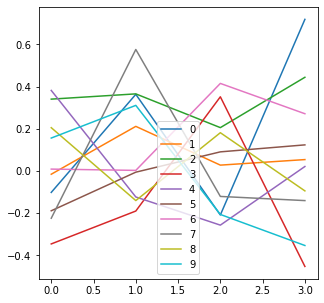

In [8]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

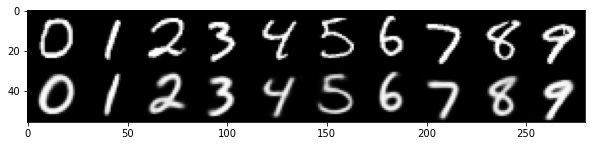

In [9]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [10]:
from XAE.sampler import gaus

exn = 5

In [11]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

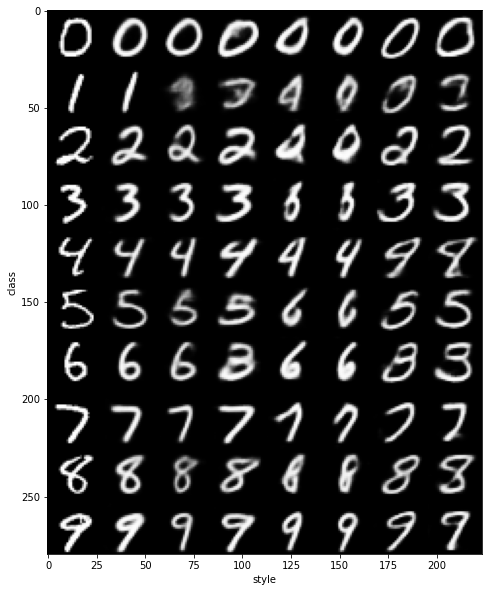

In [12]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [13]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

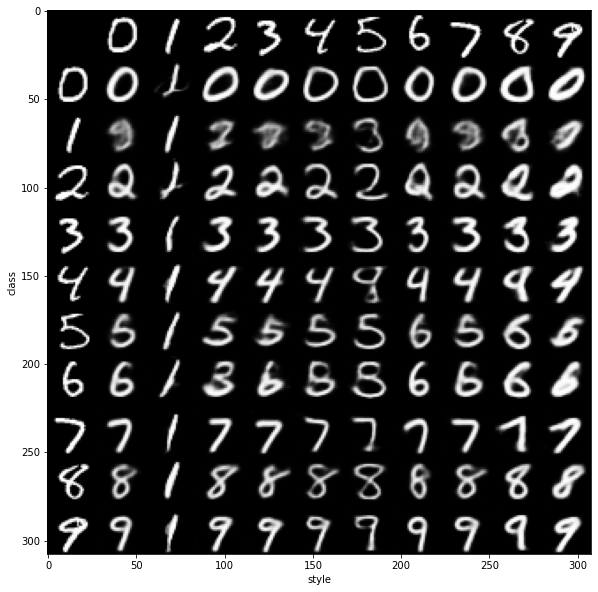

In [14]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()